In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2, os, glob

np.set_printoptions(threshold=np.inf) # NumPy 설정
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # CUDA 가시성 설정 (GPU 사용시 필요)

# GPU 메모리 구성 설정 (GPU 사용시 필요)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # TensorFlow 2.x에서는 set_memory_growth 대신에 메모리 할당 옵션을 설정하는 코드
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# 뇌종양 분할( brain tumor)


- image
  - mri는 4가지 양식(t1,t1ce,t2,flair)으로 촬영되었고, 4개를 하나의 데이터(RGB Image가 3channel인것과 같음)로 사용함
![image-2.png](attachment:image-2.png)

- label
  - 0 : 배경
  - 1 : 전체 종양(Whole tumor)
  - 2 : 핵심 종양(Tumor core)
  - 3 : 조영제 등으로 인해 강조된 종양(enhancing tumor)

![image.png](attachment:image.png)

### 데이터 가져오기

In [ ]:
train_images =  np.load('/home/nas/data/eunju/npy/z-score/train_images.npy')
val_images =  np.load('/home/nas/data/eunju/npy/z-score/val_images.npy')
test_images =  np.load('/home/nas/data/eunju/npy/z-score/test_images.npy')

train_labels =  np.load('/home/nas/data/eunju/MICCAI/non_zero/train_labels.npy')
val_labels =  np.load('/home/nas/data/eunju/MICCAI/non_zero/val_labels.npy')
test_labels =  np.load('/home/nas/data/eunju/MICCAI/non_zero/test_labels.npy')

train_labels = np.where(train_labels == 4, 3, train_labels)
test_labels = np.where(test_labels == 4, 3, test_labels)
val_labels = np.where(val_labels == 4, 3, val_labels)

print("train_images :",train_images.shape)
print("train_labels :",train_labels.shape)
print("val_images   :",val_images.shape)
print("val_labels   :",val_labels.shape)
print("test_images  :",test_images.shape)
print("test_labels  :",test_labels.shape)

train_images : (3906, 240, 240, 4)
train_labels : (3906, 240, 240)
val_images   : (1302, 240, 240, 4)
val_labels   : (1302, 240, 240)
test_images  : (1302, 240, 240, 4)
test_labels  : (1302, 240, 240)


In [ ]:
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels, num_classes=4)
val_labels = to_categorical(val_labels, num_classes=4)

### 데이터 확인

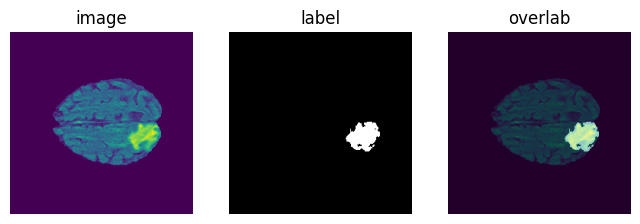

In [ ]:
num = 0
plt.figure(figsize=(8,3))
plt.subplot(131); plt.imshow(test_images[num,:,:,3]);plt.title("image"); plt.axis("off")
plt.subplot(132); plt.imshow(test_labels[num,:,:], cmap='gray');plt.title("label"); plt.axis("off")

plt.subplot(133); plt.imshow(test_labels[num,:,:], cmap='gray');plt.title("overlab"); plt.axis("off")
plt.subplot(133); plt.imshow(test_images[num,:,:,3], alpha=0.5); plt.axis("off");plt.show()

### loss ( dice, bec dice loss)
- 분할에 사용할 수 있는 손실함수들 참고
- https://www.kaggle.com/code/sungjunghwan/loss-function-of-image-segmentation
- https://medium.com/@kimminha1994/loss-functions-for-semantic-segmentation-634a982de702

![image-3.png](attachment:image-3.png)

- 여기서는 dice + bce loss를 사용하였음

In [ ]:
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

# Binary Crossentropy Dice Loss
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# ELL
def ell_loss(y_true, y_pred, alpha=0.5):
    return alpha * binary_crossentropy(y_true, y_pred) + (1 - alpha) * dice_loss(y_true, y_pred)

### 모델 평가 지표

In [ ]:
def sensitivity(cm, n):  # recall, True Positive Rate
    sen = []
    for i in range(n):
        tp = cm[i][i]
        sen1 = round((tp / np.sum(cm[i, :])), 4)
        sen.append(sen1)
    return sen

class_name = ["0", "1", "2", "3"]

def specificity(cm, n): # True_negative_rate
    TNR = []
    all = np.sum(cm)
    for i in range(n):
        TP = cm[i][i]
        FP = np.sum(cm[:,i]) - TP
        FN = np.sum(cm[i,:]) - TP
        TN = all - FP - FN - TP
        tnr = round((TN/(FP+TN)),4)
        TNR.append(tnr)
    return TNR

def F1_score(cm, n):
    f1_score = []

    for i in range(n):
        TP = cm[i][i]
        FP = np.sum(cm[:,i]) - TP
        FN = np.sum(cm[i,:]) - TP
        f1score = round(((2*TP) / (2*TP+FP+FN)),4)
        f1_score.append(f1score)
    return f1_score

def precision(cm, n): # Ppv
    positive_predictive_value = []

    for i in range(n):
        TP = cm[i][i]
        TP_FP = np.sum(cm[:,i])
        ppv = round((TP/TP_FP), 4)
        positive_predictive_value.append(ppv)
    return positive_predictive_value

### 시각화

In [ ]:
def visual_num(n) :
    num =n
    test_image = test_images[num]
    test_label = test_labels[num]
    prediction = model.predict(np.expand_dims(test_image, axis=0))[0]
    prediction = np.argmax(prediction, axis=-1)
# 예측 결과 시각화
    plt.figure(figsize=(9,5))
    plt.subplot(241) ;  plt.imshow(test_image[:,:,0], cmap='gray') ; plt.title('T1');plt.axis('off')
    plt.subplot(242) ;  plt.imshow(test_image[:,:,1], cmap='gray') ; plt.title('T1ce'); plt.axis('off')
    plt.subplot(243) ;  plt.imshow(test_image[:,:,2], cmap='gray') ; plt.title('T2'); plt.axis('off')
    plt.subplot(244) ;  plt.imshow(test_image[:,:,3], cmap='gray') ; plt.title('flair'); plt.axis('off')
    t1 = np.where(test_label == 0, 1,0).astype('uint8')
    t2 = np.where(test_label == 1, 1,0).astype('uint8')
    t3 = np.where(test_label == 2, 1,0).astype('uint8')
    t4 = np.where(test_label == 3, 1,0).astype('uint8')
    plt.subplot(245); plt.imshow(test_label, cmap='gray'); plt.title('Ground Truth');plt.axis('off')
    plt.subplot(2,4,6) ; plt.imshow(prediction, cmap='gray'); plt.title('Predicted');plt.axis('off')
    plt.subplot(2,4,7) ; plt.imshow(abs(test_label-prediction), cmap='gray'); plt.title('GT - pred');plt.axis('off')
    plt.subplot(2,4,8) ; plt.imshow(test_image[:,:,3], cmap='gray'); plt.title('flair overlab');plt.axis('off')
    plt.subplot(2,4,8) ; plt.imshow(abs(test_label-prediction), cmap='jet',alpha=0.5);plt.axis('off')
    t = test_label.flatten()
    p = prediction.flatten()
    matches = t == p
    num_mismatches = len(matches) - np.count_nonzero(matches)
    mismatch_indices = np.where(matches == False)[0]
    print("mismatched labels:", num_mismatches)
    plt.tight_layout();plt.show()

<br>

----

<br>

### 모델 구조
- 구조는 u-net, inception, FPN, Dilated Convolution 등 다양하게 시도해볼 수 있음

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.models import Model

input_shape = (240, 240, 4)
inputs = Input(shape=input_shape)

# Encoder
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

# Decoder (브릿지 없이 바로 연결)
up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(pool4), conv4], axis=-1)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=-1)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=-1)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=-1)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

# Output
outputs = Conv2D(4, (1, 1), activation='softmax')(conv9)
model = Model(inputs=inputs, outputs=outputs)
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 240, 240, 4)]        0         []                            
                                                                                                  
 conv2d_34 (Conv2D)          (None, 240, 240, 64)         2368      ['input_3[0][0]']             
                                                                                                  
 conv2d_35 (Conv2D)          (None, 240, 240, 64)         36928     ['conv2d_34[0][0]']           
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 120, 120, 64)         0         ['conv2d_35[0][0]']           
 g2D)                                                                                       

In [ ]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy'])

# 커널이 죽는다면 batch_size를 줄이면 됨
history= model.fit(train_images, train_labels, epochs=100, batch_size=32, validation_data=(val_images, val_labels))

Epoch 1/100
123/123 [==============================] - 48s 259ms/step - loss: 0.1011 - accuracy: 0.9801 - val_loss: 0.0505 - val_accuracy: 0.9820
Epoch 2/100
123/123 [==============================] - 26s 207ms/step - loss: 0.0419 - accuracy: 0.9840 - val_loss: 0.0380 - val_accuracy: 0.9847
Epoch 3/100
123/123 [==============================] - 23s 189ms/step - loss: 0.0285 - accuracy: 0.9889 - val_loss: 0.0288 - val_accuracy: 0.9891
Epoch 4/100
123/123 [==============================] - 23s 191ms/step - loss: 0.0226 - accuracy: 0.9911 - val_loss: 0.0202 - val_accuracy: 0.9920
Epoch 5/100
123/123 [==============================] - 24s 193ms/step - loss: 0.0183 - accuracy: 0.9927 - val_loss: 0.0181 - val_accuracy: 0.9928
Epoch 6/100
123/123 [==============================] - 23s 190ms/step - loss: 0.0184 - accuracy: 0.9927 - val_loss: 0.0175 - val_accuracy: 0.9932
Epoch 7/100
123/123 [==============================] - 25s 200ms/step - loss: 0.0160 - accuracy: 0.9936 - val_loss: 0.0160 -

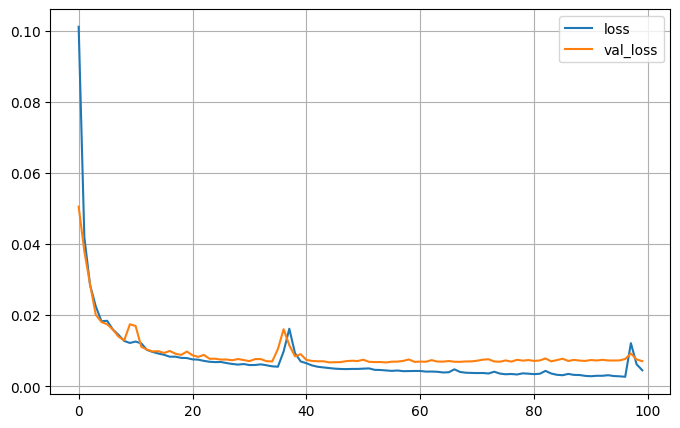

(<matplotlib.legend.Legend at 0x7fe85039ed30>, None, None)

In [ ]:
plot_target = ['loss', 'val_loss']
plt.figure(figsize=(8,5))
for each in plot_target:
    plt.plot(history.history[each], label = each)
plt.legend(), plt.grid(), plt.show()

#### test data evaluate

In [ ]:
test_label_e = to_categorical(test_labels, num_classes=4)
loss, acc = model.evaluate(test_images, test_label_e, verbose=2)

41/41 - 3s - loss: 0.0072 - accuracy: 0.9971 - 3s/epoch - 65ms/step


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(test_images)

y_true = np.argmax(test_label_e, axis=3)
y_pred = np.argmax(y_pred, axis=3)

y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

conf_mat = confusion_matrix(y_true_flat, y_pred_flat)

41/41 [==============================] - 3s 53ms/step


In [ ]:
import pandas as pd

Sensitivity = sensitivity(conf_mat, 4)
Specificity = specificity(conf_mat, 4)
f1 = F1_score(conf_mat, 4)
Positive_predictive_value = precision(conf_mat, 4)

data = {'Sensitivity': Sensitivity,
        'Specificity': Specificity,
        'F1 Score': f1,
        'Precision': Positive_predictive_value}

df = pd.DataFrame(data, index=class_name)
df.loc['Col Ave'] = df.mean()

df

,Sensitivity,Specificity,F1 Score,Precision
0,0.99880,0.95750,0.99890,0.999100
1,0.88080,0.99960,0.88200,0.883200
2,0.93520,0.99870,0.92100,0.907200
3,0.88180,0.99960,0.89110,0.900600
Col Ave,0.92415,0.98885,0.92325,0.922525


### 결과 확인
- 정답값과 예측값을 비교해보면 결과가 좋음
- 차이를 확인해보면 대부분 경계에서 오류가 있는 걸 알 수 있음
- 경계값을 잘 맞추도록 수정하면 더 좋은 결과를 얻을 수 있을 것으로 생각됨

1 )
1/1 [==============================] - 0s 51ms/step
mismatched labels: 103


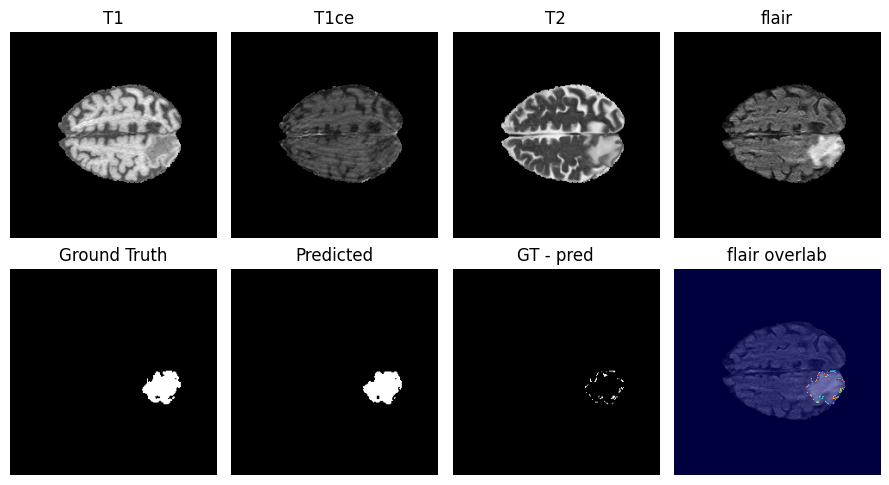

2 )
1/1 [==============================] - 0s 50ms/step
mismatched labels: 178


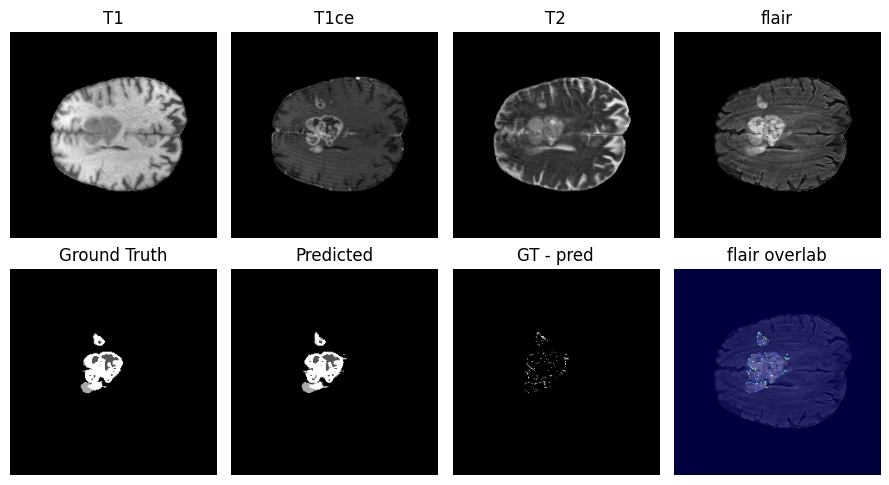

3 )
1/1 [==============================] - 0s 49ms/step
mismatched labels: 217


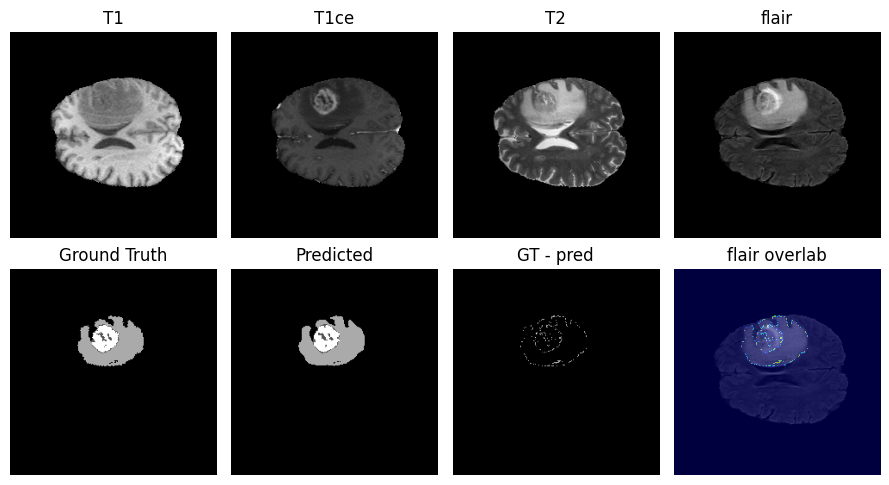

4 )
1/1 [==============================] - 0s 50ms/step
mismatched labels: 43


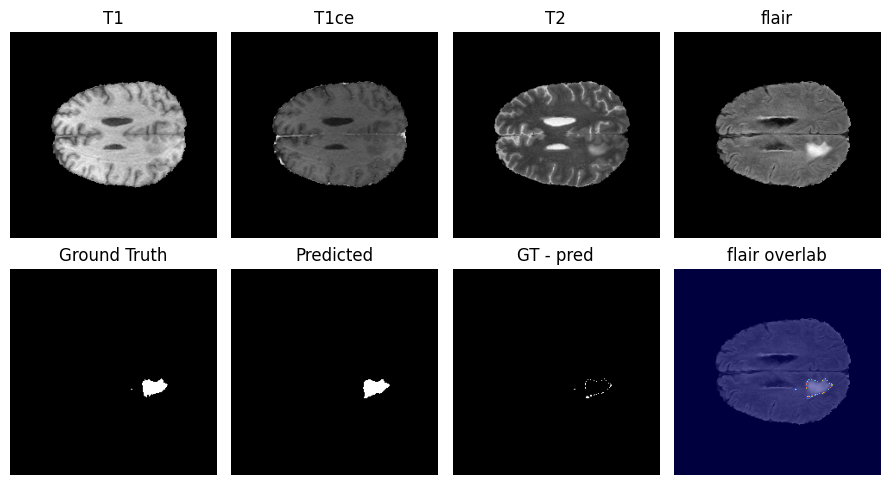

5 )
1/1 [==============================] - 0s 49ms/step
mismatched labels: 185


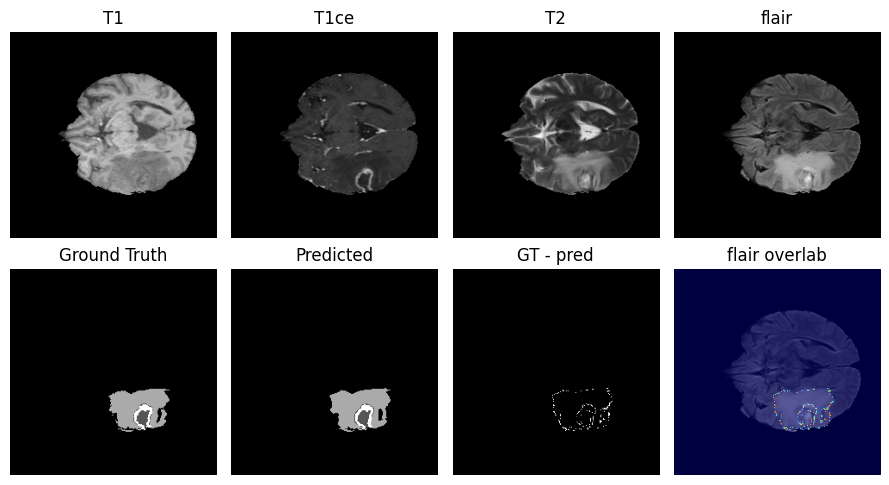

In [ ]:
for i in range(5) :
    print(i+1,")")
    visual_num(i)

### 모델 저장

In [ ]:
#model.save('../model(1).h5')

<br><br><Br>